# 1 - Imports

In [2]:
import sys
sys.path.append('/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/scripts/')
import argparse
import torch
import numpy as np
import pandas as pd
import math
import datetime

from matplotlib import pyplot as plt
import seaborn as sns

from utils import scoreCosineDistance, Score
from model_evaluator import ModelEvaluator
from settings import MODEL_EVALUATOR_DEFAULT_SETTINGS

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)
sns.set_style("darkgrid")

# 2 - Load the class

In [3]:
default_params_dict = MODEL_EVALUATOR_DEFAULT_SETTINGS

default_params_dict['model_checkpoint_folder'] = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/models/22_12_14_09_48_59_vgg_tmh_ap_fc_VGGNL_TransformerStackedAttentionPooling_c0whzsyq'
default_params_dict['model_checkpoint_file_name'] = '22_12_14_09_48_59_vgg_tmh_ap_fc_VGGNL_TransformerStackedAttentionPooling_c0whzsyq.chkpt'
default_params_dict['test_clients'] =   '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/labels/test/voxceleb1_h_protocol/22_12_09_14_13_45_27ptmd8u_bright-brook-28/clients.ndx'
default_params_dict['test_impostors'] = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/labels/test/voxceleb1_h_protocol/22_12_09_14_15_18_2mwdbd4n_snowy-sound-29/impostors.ndx'
default_params_dict['data_dir'] =       [
    '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/datasets/voxceleb_1/dev/22_12_05_21_59_21_1tu20n33_dainty-universe-5',
    '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/datasets/voxceleb_1/test/22_12_05_21_59_21_10q28l5i_splendid-thunder-6',
]
default_params_dict['dump_folder'] =    '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/models_results'
default_params_dict['evaluation_type'] = "total_length"

default_params = argparse.Namespace(**default_params_dict)

ins = ModelEvaluator(default_params)

22-12-25 11:29:32 - model_evaluator - INFO - Setting device...
22-12-25 11:29:33 - model_evaluator - INFO - Running on cuda device.
22-12-25 11:29:33 - model_evaluator - INFO - Device setted.
22-12-25 11:29:33 - model_evaluator - INFO - Setting random seed...
22-12-25 11:29:33 - model_evaluator - INFO - Random seed setted.
22-12-25 11:29:33 - model_evaluator - INFO - Loading checkpoint from /home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/models/22_12_14_09_48_59_vgg_tmh_ap_fc_VGGNL_TransformerStackedAttentionPooling_c0whzsyq/22_12_14_09_48_59_vgg_tmh_ap_fc_VGGNL_TransformerStackedAttentionPooling_c0whzsyq.chkpt
22-12-25 11:29:34 - model_evaluator - INFO - Model checkpoint was saved at epoch 33
22-12-25 11:29:34 - model_evaluator - INFO - Checkpoint loaded.
22-12-25 11:29:34 - model_evaluator - INFO - Loading data from /home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/labels/test/voxceleb1_h_protocol/22_12_09_14_13_

# 3 - Experiments

## 3.1 - Metada

In [4]:
df_meta_1 = pd.read_csv("data/vox1_meta.csv", sep = " ")

df_meta_1.rename(
    columns = {
        "VoxCeleb1_ID": "id", 
        "Gender" : "gender",
        "Nationality" : "nationality",
        "Set" : "set",
    },
    inplace = True
)

cols = ["id", "gender", "nationality", "set"]
df_meta_1 = df_meta_1[cols]

df_meta_1["id"] = df_meta_1["id"].str.strip()
df_meta_1["gender"] = df_meta_1["gender"].str.lower()
df_meta_1["gender"] = df_meta_1["gender"].str.strip()
df_meta_1["nationality"] = df_meta_1["nationality"].str.lower()
df_meta_1["nationality"] = df_meta_1["nationality"].str.strip()
df_meta_1["set"] = df_meta_1["set"].str.strip()
df_meta_1["dataset"] = "voxceleb_1"

In [5]:
df_meta_2 = pd.read_csv("data/vox2_meta.csv", sep = ",")

df_meta_2.rename(
    columns = {
        "VoxCeleb2 ID ": "id", 
        "Gender " : "gender",
        "Nationality " : "nationality",
        "Set " : "set",
    },
    inplace = True
)

cols = ["id", "gender", "set"]
df_meta_2 = df_meta_2[cols]
df_meta_2["nationality"] = None

df_meta_2["id"] = df_meta_2["id"].str.strip()
df_meta_2["gender"] = df_meta_2["gender"].str.lower()
df_meta_2["gender"] = df_meta_2["gender"].str.strip()
df_meta_2["set"] = df_meta_2["set"].str.strip()
df_meta_2["dataset"] = "voxceleb_2"

In [6]:
df_meta = pd.concat([df_meta_1, df_meta_2])

df_meta["nationality"].fillna("nulo", inplace = True)

In [7]:
df_meta.isna().sum()

id             0
gender         0
nationality    0
set            0
dataset        0
dtype: int64

In [8]:
df_meta["id"].nunique()

7365

In [9]:
len(df_meta)

7365

In [10]:
df_meta.describe()

,id,gender,nationality,set,dataset
count,7365,7365,7365,7365,7365
unique,7365,2,37,2,2
top,id10001,m,nulo,dev,voxceleb_2
freq,1,4453,6114,7205,6114


## 3.2 - Validation results

In [11]:
%%time

if False:

    start_datetime = datetime.datetime.strftime(datetime.datetime.now(), '%y-%m-%d %H:%M:%S')
    start_datetime = start_datetime.replace("-", "_").replace(" ", "_").replace(":", "_")
    
    cols = [
    "speaker_1_path",
    "speaker_2_path",
    "similarity",
    "label",
    "speaker_1_len",
    "speaker_2_len",
    "speaker_1_id",
    "speaker_2_id",
    "gender_1",
    "gender_2",
    "nationality_1",
    "nationality_2",
    ]

    df = pd.DataFrame(columns = cols)

    with torch.no_grad():

        # Switch torch to evaluation mode
        ins.net.eval()

        clients_labels = ins.input_params.test_clients
        impostor_labels = ins.input_params.test_impostors
        data_dir = ins.input_params.data_dir

        ins.clients_num = sum(1 for line in open(clients_labels))
        ins.impostors_num = sum(1 for line in open(impostor_labels))

        with open(clients_labels, 'r') as file:
            clients_lines = file.readlines()
            file.close()

        with open(impostor_labels, 'r') as file:
            impostors_lines = file.readlines()
            file.close()

        similarities = []
        for ins.batch_number, (input_1, input_2, label) in enumerate(ins.evaluating_generator):

            print(f"\r Batch {ins.batch_number} of {ins.total_batches}", end = ' ', flush = False)

            input_1 = input_1.float().to(ins.device)
            input_2 = input_2.float().to(ins.device)
            label = label.int().to(ins.device)

            if torch.cuda.device_count() > 1:
                embedding_1 = ins.net.module.get_embedding(input_1)
                embedding_2 = ins.net.module.get_embedding(input_2)
            else:
                embedding_1 = ins.net.get_embedding(input_1)
                embedding_2 = ins.net.get_embedding(input_2)

            dist = scoreCosineDistance(embedding_1, embedding_2)

            if False:
                similarities = similarities + list(
                    zip(
                        dist.cpu().detach().numpy(), 
                        label.cpu().detach().numpy(),
                        [input_1.size()[1]], # input_1 len
                        [input_2.size()[1]], # input_2 len
                    )
                )

            if label.item() == 1:
                speaker_1 = ins.clients_labels[ins.batch_number].split(" ")[0]
                speaker_2 = ins.clients_labels[ins.batch_number].split(" ")[1]
            elif label.item() == 0:
                speaker_1 = ins.impostors_labels[ins.batch_number - len(ins.clients_labels)].split(" ")[0]
                speaker_2 = ins.impostors_labels[ins.batch_number - len(ins.clients_labels)].split(" ")[1]

            line_chunks = [chunk for chunk in speaker_1.split("/") if chunk.startswith("id")]
            # Only consider directories with /id.../
            if len(line_chunks) > 0: speaker_1_id = line_chunks[0]

            line_chunks = [chunk for chunk in speaker_2.split("/") if chunk.startswith("id")]
            # Only consider directories with /id.../
            if len(line_chunks) > 0: speaker_2_id = line_chunks[0]

            gender_1 = df_meta[df_meta["id"] == speaker_1_id]["gender"].iloc[0]
            gender_2 = df_meta[df_meta["id"] == speaker_2_id]["gender"].iloc[0]
            nationality_1 = df_meta[df_meta["id"] == speaker_1_id]["nationality"].iloc[0]
            nationality_2 = df_meta[df_meta["id"] == speaker_2_id]["nationality"].iloc[0]
            #print(f"{speaker_1_id} - {nationality_1}")

            new_row = [
                speaker_1,
                speaker_2,
                dist.cpu().detach().numpy().item(),
                label.cpu().detach().numpy().item(),
                input_1.size()[1],
                input_2.size()[1],
                speaker_1_id,
                speaker_2_id,
                gender_1,
                gender_2,
                nationality_1,
                nationality_2,
            ]

            df.loc[len(df)] = new_row


            #if ins.batch_number >= 100: break

    df.to_csv(f"data/{start_datetime}_test_h_results.csv", index = False)
    print("\n")
    print("dataset saved")

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


## 3.3 - Analysis

### 3.3.1 - Load data

In [12]:
#df_name = f"data/22_12_24_19_20_42_test_h_results.csv"
df_name = f"data/22_12_23_22_13_53_test_t_results.csv"
df = pd.read_csv(df_name)

In [13]:
df.isna().sum()

speaker_1_path    0
speaker_2_path    0
similarity        0
label             0
speaker_1_len     0
speaker_2_len     0
speaker_1_id      0
speaker_2_id      0
gender_1          0
gender_2          0
nationality_1     0
nationality_2     0
dtype: int64

In [14]:
def compare_fields(a, b):
    
    if a == "nulo" or b == "nulo":
        return "nulo"
    else:
        return a == b

In [15]:
df["max_len"] = df.apply(lambda x: max(x[["speaker_1_len", "speaker_2_len"]]), axis = 1)
df["same_gender"] = df.apply(lambda x: compare_fields(x["gender_1"], x["gender_2"]), axis = 1)
df["same_nationality"] = df.apply(lambda x: compare_fields(x["nationality_1"], x["nationality_2"]), axis = 1)

In [16]:
df.head(1)

,speaker_1_path,speaker_2_path,similarity,label,speaker_1_len,speaker_2_len,speaker_1_id,speaker_2_id,gender_1,gender_2,nationality_1,nationality_2,max_len,same_gender,same_nationality
0,/home/usuaris/veu/federico.costa/git_repositor...,/home/usuaris/veu/federico.costa/git_repositor...,0.614033,1,566,678,id10270,id10270,f,f,usa,usa,678,True,True


In [17]:
clients_similarities = df[df["label"] == 1]["similarity"]
impostors_similarities = df[df["label"] == 0]["similarity"]

clients_len = df[df["label"] == 1]["max_len"]
impostors_len = df[df["label"] == 0]["max_len"]

clients_same_gender = df[df["label"] == 1]["same_gender"]
impostors_same_gender = df[df["label"] == 0]["same_gender"]

clients_same_nationality = df[df["label"] == 1]["same_nationality"]
impostors_same_nationality = df[df["label"] == 0]["same_nationality"]

#ins.IM = [similarity for similarity, label, len_1, len_2 in similarities if label == 0]

In [18]:
thresholds = np.arange(-1,1,0.01)

FRR, FAR = np.zeros(len(thresholds)), np.zeros(len(thresholds))
for idx,th in enumerate(thresholds):
    FRR[idx] = Score(clients_similarities, th,'FRR')
    FAR[idx] = Score(impostors_similarities, th,'FAR')

EER_Idx = np.argwhere(np.diff(np.sign(FAR - FRR)) != 0).reshape(-1)
if len(EER_Idx)>0:
    if len(EER_Idx)>1:
        EER_Idx = EER_Idx[0]
    EER = round((FAR[int(EER_Idx)] + FRR[int(EER_Idx)])/2,4)
else:
    EER = 50.00
    
threshold = thresholds[EER_Idx][0]

In [19]:
err_clients_len = df[(df["label"] == 1) & (df["similarity"] < threshold)]["max_len"]
err_impostors_len = df[(df["label"] == 0) & (df["similarity"] >= threshold)]["max_len"]

### 3.3.2 - EER curves

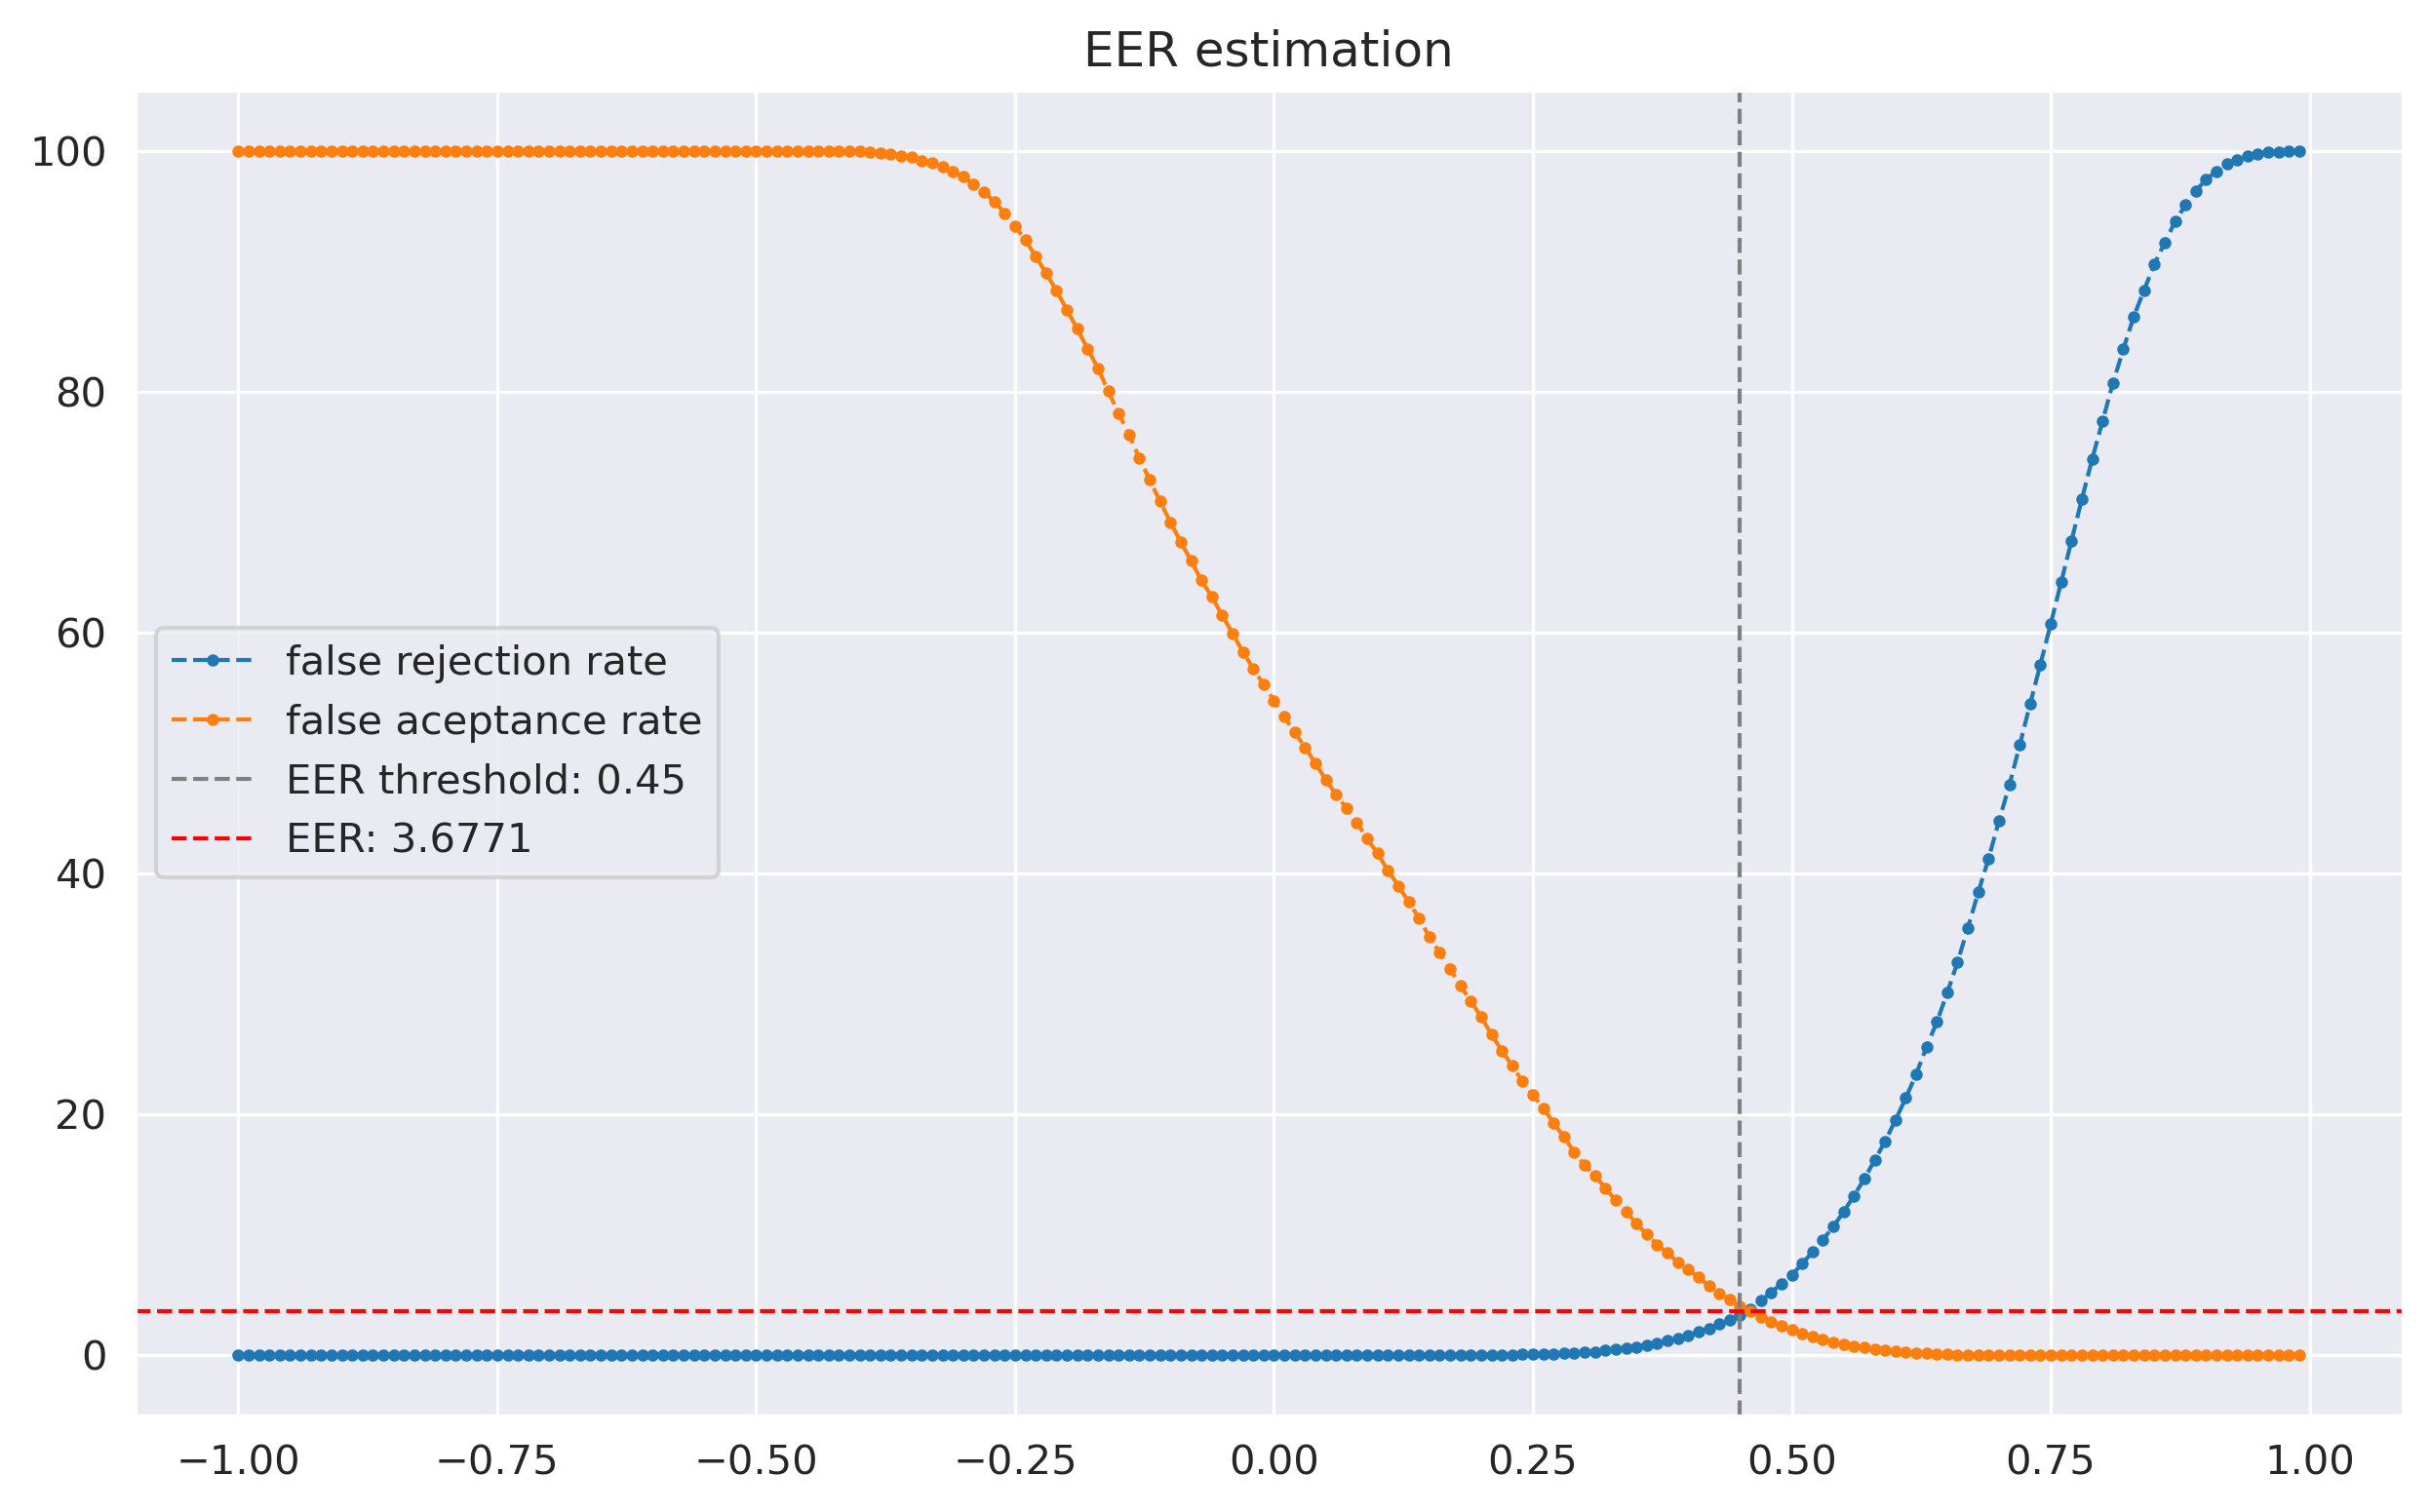

In [20]:
plt.figure(figsize = (10,6), dpi = 300)

plt.plot(thresholds, FRR, "--o", markersize = 2, linewidth = 1, label = "false rejection rate")
plt.plot(thresholds, FAR, "--o", markersize = 2, linewidth = 1, label = "false aceptance rate")


plt.axvline(threshold, linestyle= "--", linewidth = 1, color = "grey", label = f"EER threshold: {threshold:.2f}")
plt.axhline(EER, linestyle= "--", linewidth = 1, color = "red", label = f"EER: {EER}")

#plt.xlim(0.5, 0.6)
#plt.ylim(0, 8)

plt.title("EER estimation")
plt.legend()
#plt.savefig(f"data/{start_datetime}_test_eer.jpg")
plt.show()

In [21]:
err_clients = ( (df["label"] == 1) & (df["similarity"] < threshold) ).sum()
err_clients_pctg = err_clients * 100 / (df["label"] == 1).sum()
err_clients_pctg

3.340070205297309

In [22]:
err_impostors = ( (df["label"] == 0) & (df["similarity"] >= threshold) ).sum()
err_impostors_pctg = err_impostors * 100 / (df["label"] == 0).sum()
err_impostors_pctg

4.014035833909299

In [23]:
(err_clients_pctg + err_impostors_pctg) / 2

3.6770530196033038

In [24]:
err = ( (df["label"] == 1) & (df["similarity"] < threshold) ).sum() + ( (df["label"] == 0) & (df["similarity"] >= threshold) ).sum()
err_pctg = err * 100 / len(df)
err_pctg

3.6771157374172447

In [25]:
#clients_sim = [similarity for similarity, label, len_1, len_2 in similarities if label == 1]
#clients_len = [max(len_1, len_2) for similarity, label, len_1, len_2 in similarities if label == 1]

In [26]:
#err_clients_len = [max(len_1, len_2) for similarity, label, len_1, len_2 in similarities if label == 1 if similarity < threshold]
#err_impostors_len = [max(len_1, len_2) for similarity, label, len_1, len_2 in similarities if label == 0 if similarity >= threshold]

Preguntas

- Clientes
    - de los errores, influye la len? Todos los audios son más largos que 350 frames, que es con lo que se entrenó. 
    - grafico de los errores con len_1 en x y len_2 en eje y. mismo grafico para los correctos
- Impostores
    - de los errores. influye la len?
    - influye el genero?
    - influye la nacionalidad?

### 3.3.2 - Clients analysis

#### 3.3.2.1 - Lenght error analysis

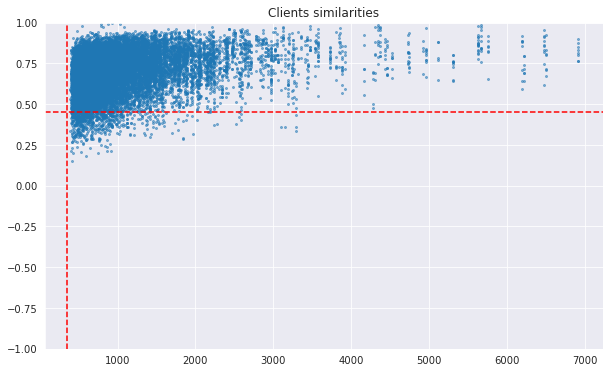

In [27]:
plt.figure(figsize = (10,6))

plt.plot(clients_len, clients_similarities, "o", markersize = 2, alpha = 0.5)

plt.axhline(threshold, linestyle= "--", color = "red", label = f"threshold: {threshold}")
plt.axvline(350, linestyle= "--", color = "red", label = f"trained frames len")

plt.ylim(-1,1)
#plt.xlim(300,800)

plt.title("Clients similarities")
plt.show()

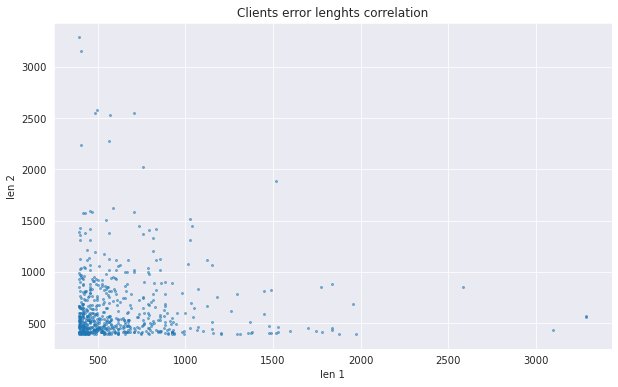

In [28]:
plt.figure(figsize = (10,6))

plt.plot(
    df[(df["label"] == 1) & (df["similarity"] < threshold)]["speaker_1_len"], 
    df[(df["label"] == 1) & (df["similarity"] < threshold)]["speaker_2_len"], 
    "o", markersize = 2, alpha = 0.5,
)

#plt.axhline(threshold, linestyle= "--", color = "red", label = f"threshold: {threshold}")
#plt.axvline(350, linestyle= "--", color = "red", label = f"trained frames len")

#plt.ylim(-1,1)
#plt.xlim(300,800)

plt.xlabel("len 1")
plt.ylabel("len 2")

plt.title("Clients error lenghts correlation")
plt.show()

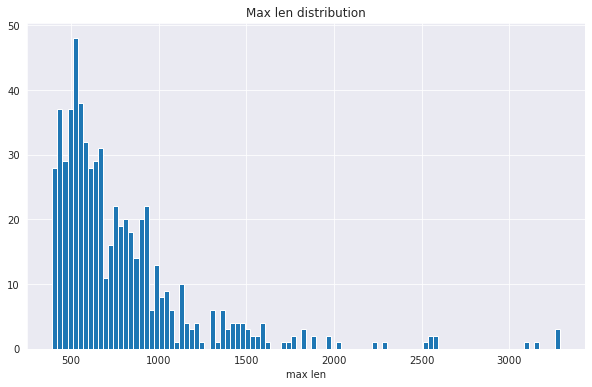

In [29]:
plt.figure(figsize = (10,6))
plt.hist(err_clients_len, bins = 100)

plt.title("Max len distribution")
plt.xlabel("max len")
plt.show()

In [30]:
pd.Series(err_clients_len).describe([.01, .1, .25, .5, .75, .9, .99])

count     628.000000
mean      790.420382
std       419.818843
min       394.000000
1%        410.000000
10%       450.000000
25%       522.000000
50%       670.000000
75%       902.000000
90%      1294.000000
99%      2574.440000
max      3286.000000
Name: max_len, dtype: float64

### 3.3.3 - Impostors analysis

#### 3.3.3.1 - Length error analysis

#### 3.3.3.2 - Gender error analysis

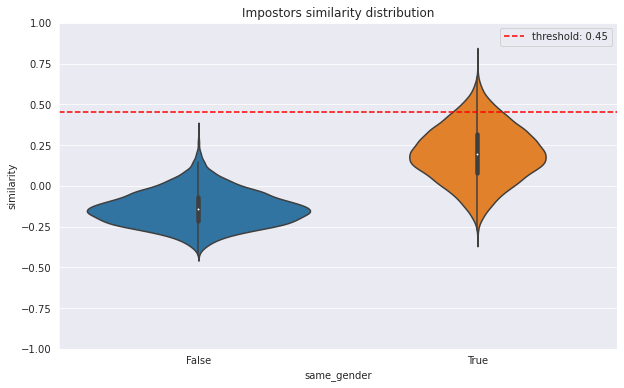

In [43]:
plt.figure(figsize = (10,6))

sns.violinplot(
    data = df[df["label"] == 0],
    x = "same_gender",
    y = "similarity",
)

plt.axhline(threshold, linestyle = "--", color = "red", label = f"threshold: {threshold:.2f}")

plt.ylim(-1,1)

plt.title("Impostors similarity distribution")
plt.legend()
plt.show()

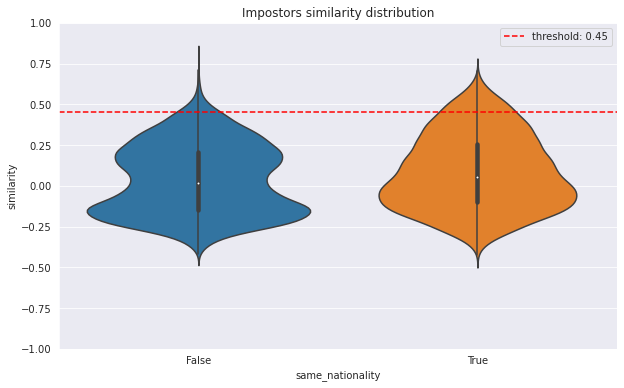

In [44]:
plt.figure(figsize = (10,6))

sns.violinplot(
    data = df[df["label"] == 0],
    x = "same_nationality",
    y = "similarity",
)

plt.axhline(threshold, linestyle = "--", color = "red", label = f"threshold: {threshold:.2f}")

plt.ylim(-1,1)

plt.title("Impostors similarity distribution")
plt.legend()
plt.show()

In [46]:
df[(df["label"] == 0) & (df["similarity"] >= threshold)].groupby(["same_gender", "same_nationality"])["speaker_1_id"].count()

same_gender  same_nationality
True         False               259
             True                496
Name: speaker_1_id, dtype: int64

In [40]:
df[(df["label"] == 0) & (df["same_gender"] == 1)]["similarity"].describe([.1, .25, .5, .75, .9])

count    10717.000000
mean         0.197196
std          0.168887
min         -0.317490
10%         -0.024779
25%          0.081506
50%          0.195595
75%          0.316474
90%          0.420564
max          0.792427
Name: similarity, dtype: float64

In [ ]:
df[(df["label"] == 0) & (df["same_gender"] == 0)]["similarity"].describe([.1, .25, .5, .75, .9])

In [ ]:
df[(df["label"] == 0) & (df["same_nationality"] == 1)]["similarity"].describe([.1, .25, .5, .75, .9])

In [ ]:
df[(df["label"] == 0) & (df["same_nationality"] == 0)]["similarity"].describe([.1, .25, .5, .75, .9])

In [ ]:
cols = ["similarity", "label", "gender_1", "gender_2", "same_nationality"]
df[(df["label"] == 0) & (df["similarity"] >= threshold)].head()

In [ ]:
df[(df["label"] == 0) & (df["similarity"] >= threshold)].groupby("same_gender")["speaker_1_id"].count()

In [ ]:
df[(df["label"] == 1) & (df["same_gender"] == 1)]["similarity"].describe([.1, .25, .5, .75, .9])

In [ ]:
df[(df["label"] == 1) & (df["same_gender"] == 0)]["similarity"].describe([.1, .25, .5, .75, .9])

In [ ]:
df[(df["label"] == 0) & (df["same_gender"] == 1)]["similarity"].describe([.1, .25, .5, .75, .9])

In [ ]:
df[(df["label"] == 0) & (df["same_gender"] == 0)]["similarity"].describe([.1, .25, .5, .75, .9])

In [ ]:
threshold

In [ ]:
pd.Series(err_impostors_len).describe()

In [ ]:
 plt.figure(figsize = (10,6))

plt.plot(impostors_len, impostors_similarities, "o", markersize = 2, alpha = 0.5)
plt.axhline(threshold, linestyle= "--", color = "red", label = f"threshold: {threshold}")

plt.ylim(-1,1)

plt.title("Impostors similarities")
plt.show()